In [2]:
# !wget http://download.cs.stanford.edu/deep/ForestNetDataset.zip
# !unzip ForestNetDataset.zip

In [56]:
# !wget https://media.githubusercontent.com/media/BioWar/Satellite-Image-Segmentation-using-Deep-Learning-for-Deforestation-Detection/main/Dataset/deforestation_tfrecords.tar.gz
# !tar -zxf deforestation_tfrecords.tar.gz
# !rm deforestation_tfrecords.tar.gz

In [13]:
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [4]:
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import os
from shapely.geometry.polygon import Polygon
from skimage.io import imread
import tensorflow as tf

df = pd.read_csv('ForestNetDataset/train.csv')
df.head()

,label,merged_label,latitude,longitude,year,example_path
0,Timber plantation,Plantation,4.430849,96.101634,2014,examples/4.430849118860583_96.1016343478138
1,Other,Other,1.332341,109.374229,2012,examples/1.3323406178609702_109.37422873130464
2,Grassland shrubland,Grassland shrubland,-1.720266,115.006996,2016,examples/-1.7202663845775041_115.00699582064483
3,Small-scale agriculture,Smallholder agriculture,-2.248346,104.135786,2011,examples/-2.248346072674411_104.1357857482906
4,Other large-scale plantations,Plantation,-2.100800,113.022376,2008,examples/-2.100800102991412_113.02237632340159


In [5]:
index = 7
path = os.path.join('ForestNetDataset', df.iloc[index,-1])
images = sorted(glob(f'{path}/**/*.png',recursive=True))
images, df.iloc[index, 1:5]

(['ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2013_07_01_cloud_0.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_05_01_cloud_3240.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_05_01_cloud_3348.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_08_21_cloud_264.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_08_21_cloud_372.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2015_07_07_cloud_0.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2015_07_23_cloud_0.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2016_09_27_cloud_0.png',
  'ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/composite.png'],
 merged_label    Plantation
 latitu

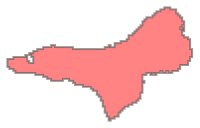

In [6]:
import pickle

with open(f'{path}/forest_loss_region.pkl', 'rb') as fopen:
    data = pickle.load(fopen)
    
data

In [7]:
points = []
if isinstance(data, Polygon):
    data = [data]
for p in data:
    points.append(np.around(np.array(p.exterior.coords.xy).T).astype(np.int32))

ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2013_07_01_cloud_0.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_05_01_cloud_3240.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_05_01_cloud_3348.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_08_21_cloud_264.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2014_08_21_cloud_372.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2015_07_07_cloud_0.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2015_07_23_cloud_0.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/2016_09_27_cloud_0.png
ForestNetDataset/examples/-0.6522445100247509_109.9206187702712/images/visible/composite.png


/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':
/home/husein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()


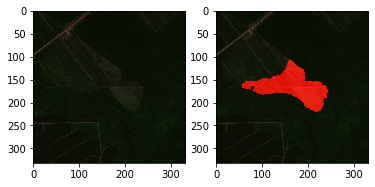

In [20]:
for image in images:
    print(image)
    image = imread(image)
    copied = np.copy(image)
    mask = np.zeros_like(image)
    mask = cv2.fillPoly(mask, pts = points, color =(255,0,0))
    copied = cv2.addWeighted(copied, 1, mask, 0.8, 0)
    
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(copied)

In [9]:
def _parse_image_function(example_proto):
    image_feature_description = {
        "image": tf.compat.v1.FixedLenFeature([], tf.string),
        "mask": tf.compat.v1.FixedLenFeature([], tf.string),
    }
    features = tf.compat.v1.parse_single_example(example_proto, features=image_feature_description)
    image = tf.image.decode_png(features['image'], channels = 3)
    image = tf.image.resize(image, [512, 512])
    image = tf.cast(image, tf.float32) / 255.0
    features['image'] = image
    mask = tf.io.decode_raw(features['mask'], out_type="float")
    mask = tf.reshape(mask, [512, 512, 3])
    mask = tf.cast(mask, tf.float32)
    features['mask'] = mask
    return features

dataset_path = glob('content/gdrive/MyDrive/Dataset/*.tfrec')
raw_image_dataset = tf.data.TFRecordDataset(dataset_path)
dataset = raw_image_dataset.map(_parse_image_function)
dataset = dataset.make_one_shot_iterator().get_next()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [10]:
dataset

{'image': <tf.Tensor 'IteratorGetNext:0' shape=(512, 512, 3) dtype=float32>,
 'mask': <tf.Tensor 'IteratorGetNext:1' shape=(512, 512, 3) dtype=float32>}

In [11]:
sess = tf.Session()

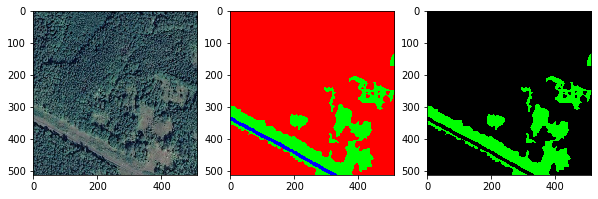

In [37]:
r = sess.run(dataset)
mask = np.zeros_like(r['mask'])
mask[:,:,1] = 1
mask = cv2.bitwise_and(r['mask'], mask)
plt.figure(figsize = (10, 5))
plt.subplot(1,3,1)
plt.imshow(r['image'])
plt.subplot(1,3,2)
plt.imshow(r['mask'])
plt.subplot(1,3,3)
plt.imshow(mask)

In [38]:
segmap = SegmentationMapsOnImage(mask[:,:,1:2].astype(np.int32), shape=r['image'].shape)

In [53]:
seq = iaa.Sequential([
    iaa.Affine(rotate=(-90, 90)),
    iaa.Add((-5, 5)),
    iaa.Clouds(),
    iaa.CropToFixedSize(width=256, height=256)
], random_order=True)

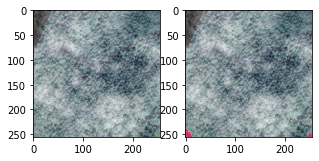

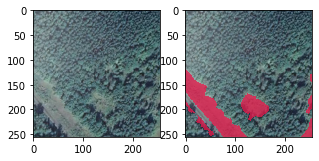

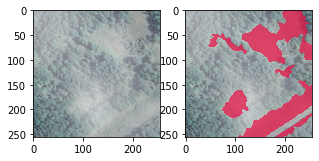

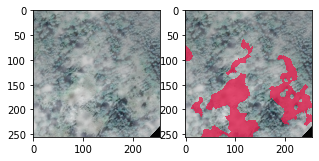

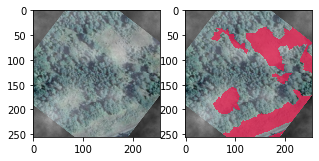

In [54]:
images_aug = []
segmaps_aug = []
for _ in range(5):
    img = (r['image'] * 255.0).astype(np.uint8)
    images_aug_i, segmaps_aug_i = seq(image=img, segmentation_maps=segmap)
    
    plt.figure(figsize = (5, 3))
    plt.subplot(1,2,1)
    plt.imshow(images_aug_i)
    plt.subplot(1,2,2)
    plt.imshow(segmaps_aug_i.draw_on_image(images_aug_i)[0])